<a href="https://colab.research.google.com/github/ernyo/SC3000/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install "pygame>=2.1.0"
!pip install gym[classic_control] --no-deps
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [8]:
!pip install numpy pytest
!pip install tensorflow
!pip install --upgrade keras

## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from abc import ABC, abstractmethod
import numpy as np
import pytest
from collections import defaultdict

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [2]:
class Agent(ABC):
    """Abstract class for agents interacting with OpenAI Gym environments."""

    def __init__(self, env: gym.Env):
        self.env = env

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """Select an action based on the current state."""
        pass


class RandomCartPoleAgent(Agent):
    """A simple agent that selects random actions."""

    def select_action(self, state: np.ndarray) -> int:
        return self.env.action_space.sample()



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
%%writefile test_agent.py
from abc import ABC, abstractmethod
import pytest
import gym
import numpy as np

class Agent(ABC):
    """Abstract class for agents interacting with OpenAI Gym environments."""

    def __init__(self, env: gym.Env):
        self.env = env

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """Select an action based on the current state."""
        pass


class RandomCartPoleAgent(Agent):
    """A simple agent that selects random actions."""

    def select_action(self, state: np.ndarray) -> int:
        return self.env.action_space.sample()

@pytest.fixture
def env():
    """Fixture to create and close the CartPole environment."""
    environment = gym.make("CartPole-v1")
    yield environment
    environment.close()


@pytest.fixture
def agent(env):
    """Fixture to create an instance of a RandomCartPoleAgent."""
    return RandomCartPoleAgent(env)


def test_agent_inheritance():
    """Ensure RandomCartPoleAgent is a subclass of Agent."""
    assert \
      issubclass(RandomCartPoleAgent, Agent), \
      "RandomCartPoleAgent must inherit from Agent."


def test_environment_creation(env):
    """Test that the environment initializes correctly."""
    state_tuple = env.reset()
    state = np.array(state_tuple[0])  # Convert to numpy array
    assert state is not None, "Environment reset should return a valid state."
    assert isinstance(state, np.ndarray), "State should be a numpy array."


def test_valid_action(env, agent):
    """Test that the agent selects a valid action."""
    state_tuple = env.reset()
    state = np.array(state_tuple[0])  # Convert to numpy array
    action = agent.select_action(state)
    assert \
      env.action_space.contains(action), \
      "Agent selected an invalid action."


def test_step_function(env, agent):
    """Test taking a step in the environment."""
    state_tuple = env.reset()
    state = np.array(state_tuple[0])  # Convert to numpy array
    action = agent.select_action(state)
    next_state, reward, terminated, truncated = env.step(action) # Only 4 values

    assert next_state is not None, "Next state should be a valid array."
    assert \
      isinstance(next_state, np.ndarray), \
      "Next state should be a numpy array."
    assert isinstance(reward, float), "Reward should be a float."
    assert isinstance(terminated, bool), "Terminated should be a boolean."

    # Fix: Allow truncated to be either a boolean or dictionary
    assert \
      isinstance(truncated, (bool, dict)), \
      f"Truncated should be a boolean or dictionary, but got {type(truncated)}."


def test_run_episode(env, agent):
    """Test running one episode without errors."""
    state_tuple = env.reset()
    state = np.array(state_tuple[0])  # Convert to numpy array
    done = False
    steps = 0

    while not done and steps < 200:
        action = agent.select_action(state)
        state, _, terminated, truncated = env.step(action)  # Only 4 values
        done = terminated or truncated
        steps += 1

    assert steps > 0, "Agent should run for at least one step."


def test_average_reward_threshold(env, agent):
    """Test that the agent achieves a minimum reward over multiple episodes."""
    num_episodes = 10
    min_average_reward = 10  # Modify based on expectations

    total_reward = 0
    for _ in range(num_episodes):
        state_tuple = env.reset()
        state = np.array(state_tuple[0])  # Convert to numpy array
        done = False
        episode_reward = 0

        while not done:
            action = agent.select_action(state)
            state, reward, terminated, truncated = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_reward += episode_reward

    avg_reward = total_reward / num_episodes
    assert \
      avg_reward >= min_average_reward, \
      f"Average reward {avg_reward} is below threshold {min_average_reward}."


Overwriting test_agent.py


In [4]:
!pytest test_agent.py -v

======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.4, pluggy-1.5.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: langsmith-0.3.8, typeguard-4.4.1, anyio-3.7.1
collected 6 items                                                                                  

test_agent.py::test_agent_inheritance PASSED                                                 [ 16%]
test_agent.py::test_environment_creation PASSED                                              [ 33%]
test_agent.py::test_valid_action PASSED                                                      [ 50%]
test_agent.py::test_step_function PASSED                                                     [ 66%]
test_agent.py::test_run_episode PASSED                                                       [ 83%]
test_agent.py::test_average_reward_threshold PASSED                                          [100%]

===================

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [5]:
class Agent(ABC):
    """Abstract class for agents interacting with Gym environments."""

    def __init__(self, env: gym.Env):
        self.env = env

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """Select an action based on the current state."""
        pass

In [6]:
import numpy as np
import random
import gymnasium as gym
from collections import defaultdict

class MonteCarloAgent(Agent):
    """Monte Carlo Control Agent for environments with continuous state spaces (CartPole)."""

    def __init__(self, env: gym.Env, bins=(6, 6, 6, 6), epsilon=0.1, gamma=0.99):
        super().__init__(env)
        self.epsilon = epsilon  # Exploration probability
        self.gamma = gamma  # Discount factor

        # Define bins for discretization
        self.bins = bins
        self.state_bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], self.bins[i] - 1)
                           for i in range(env.observation_space.shape[0])]

        # Initialize Q-values and returns
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))  # Ensure NumPy arrays for Q-values
        self.returns = defaultdict(list)

        # Policy: initially random
        self.policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)

    def discretize_state(self, state):
        """Convert a continuous state to a discrete tuple for indexing."""
        discretized = tuple(np.digitize(state[i], self.state_bins[i]) for i in range(len(state)))
        return discretized

    def select_action(self, state):
        """Epsilon-greedy action selection."""
        discrete_state = self.discretize_state(state)
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return int(np.argmax(self.q_values[discrete_state]))  # Exploit best action (ensure integer output)

    def generate_episode(self):
        """Generate an episode using the current policy."""
        episode = []
        state, _ = self.env.reset()
        state = self.discretize_state(state)
        done = False
        total_reward = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            next_state = self.discretize_state(next_state)
            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            done = terminated or truncated

        return episode, total_reward

    def update_policy(self):
        """Update the policy based on Q-values (greedy policy)."""
        for state in self.q_values.keys():
            best_action = np.argmax(self.q_values[state])
            self.policy[state] = np.ones(self.env.action_space.n) * (self.epsilon / self.env.action_space.n)
            self.policy[state][best_action] += 1 - self.epsilon  # Exploit best action

    def policy_evaluation(self, episode):
        """Monte Carlo first-visit evaluation to update Q-values."""
        G = 0
        visited = set()

        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward  # Compute return

            # First-visit MC: Only update if state-action pair is encountered for the first time
            if (state, action) not in visited:
                visited.add((state, action))
                self.returns[(state, action)].append(G)
                self.q_values[state][action] = np.mean(self.returns[(state, action)])  # Average returns

        self.update_policy()

    def train(self, num_episodes):
      """Train using Monte Carlo Control and return average reward."""
      cumulative_reward = 0
      for _ in range(num_episodes):
          episode, episode_reward = self.generate_episode()  # Generate episode and get total reward
          self.policy_evaluation(episode)  # Update Q-values
          cumulative_reward += episode_reward  # Track cumulative reward

      return cumulative_reward / num_episodes  # Return average reward


In [9]:
import tensorflow as tf
print(tf.__version__)  # Should output the installed TensorFlow version


2.18.0


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
import gymnasium as gym
import numpy as np

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size=state_size, action_size=action_size)
episodes = 5000

for e in range(episodes):
    state, _ = env.reset()  # ✅ Unpack the tuple correctly
    state = np.reshape(state, [1, state_size])

    for time in range(500):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)  # ✅ Ensure correct unpacking
        next_state = np.reshape(next_state, [1, state_size])

        done = terminated or truncated  # ✅ Proper handling of "done" condition
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            break

if len(agent.memory) > 32:
    agent.replay(32)


Streaming output truncated to the last 5000 lines.
Episode: 65/5000, Score: 36, Epsilon: 1.0000
Episode: 66/5000, Score: 17, Epsilon: 1.0000
Episode: 67/5000, Score: 24, Epsilon: 1.0000
Episode: 68/5000, Score: 9, Epsilon: 1.0000
Episode: 69/5000, Score: 30, Epsilon: 1.0000
Episode: 70/5000, Score: 30, Epsilon: 1.0000
Episode: 71/5000, Score: 29, Epsilon: 1.0000
Episode: 72/5000, Score: 13, Epsilon: 1.0000
Episode: 73/5000, Score: 17, Epsilon: 1.0000
Episode: 74/5000, Score: 13, Epsilon: 1.0000
Episode: 75/5000, Score: 15, Epsilon: 1.0000
Episode: 76/5000, Score: 20, Epsilon: 1.0000
Episode: 77/5000, Score: 25, Epsilon: 1.0000
Episode: 78/5000, Score: 19, Epsilon: 1.0000
Episode: 79/5000, Score: 13, Epsilon: 1.0000
Episode: 80/5000, Score: 27, Epsilon: 1.0000
Episode: 81/5000, Score: 36, Epsilon: 1.0000
Episode: 82/5000, Score: 9, Epsilon: 1.0000
Episode: 83/5000, Score: 20, Epsilon: 1.0000
Episode: 84/5000, Score: 28, Epsilon: 1.0000
Episode: 85/5000, Score: 21, Epsilon: 1.0000
Episod

In [19]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation, _ = env.reset()
while True:
    env.render()
    #your agent goes here
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

TypeError: Wrapper.render() got an unexpected keyword argument 'mode'

For Task 1, we can show the observation and chosen action below:

In [14]:
env = gym.make("CartPole-v1")
agent = MonteCarloAgent(env)

agent.train(num_episodes=5000)  # Train the agent
state, _ = env.reset()
action = agent.select_action(state)

print("Action selected:", action)

Action selected: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

[None, None, None, None, None, None, None, None, None, None]


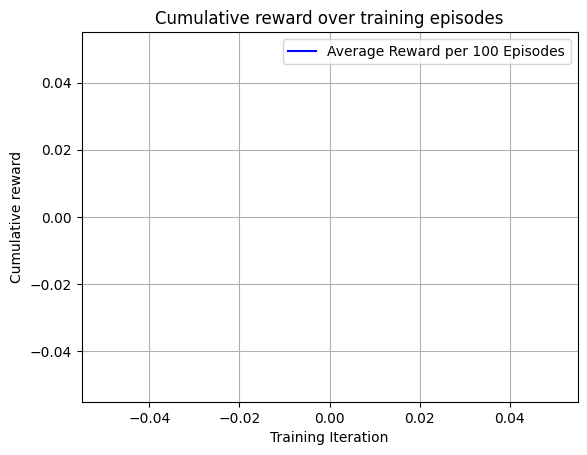

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Train over 100 iterations, each time for 100 episodes
reward_list = []
for _ in range(100):
    avg_reward = agent.train(100)  # Train for 100 episodes
    reward_list.append(avg_reward)

# Debug: Print reward values to ensure they are meaningful
print(reward_list[:10])  # Check first 10 values

# Plot the rewards
plt.plot(reward_list, label='Average Reward per 100 Episodes', color='blue')
plt.title('Cumulative reward over training episodes')
plt.ylabel('Cumulative reward')
plt.xlabel('Training Iteration')
plt.legend()
plt.grid(True)
plt.show()


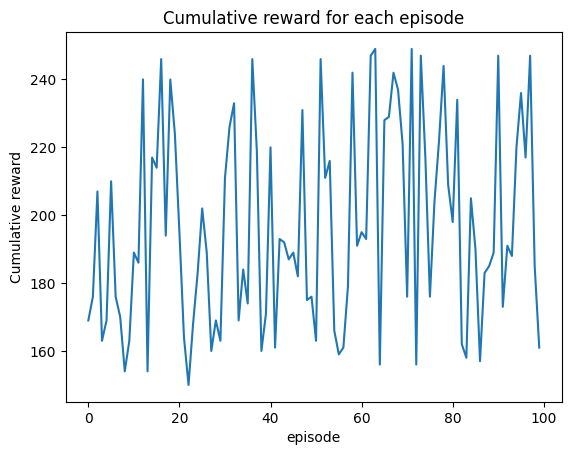

In [15]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [11]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 199.48
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [12]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa